# Introduction

**Python script for data acquisition for URANS modeling of homogeneous SST**

* **NOTE:** For LSTM model. Sequential data is input.

* **Input data**:  Horizontal velocity ($u^2 + v^2$), vertical velocity ($w^2$), buoyancy ($b^2$), and buoyancy flux ($bw$)
    - Size of a single input to NN model: $L_{\text{seq}} \times 4$, where $L_{\text{seq}}$ is the length of the time sequence
* **Output data**: Time derivative of energy terms $\frac{\partial(E_i)}{\partial t}$ (horizontal kinetic energy, vertical kinetic energy, and potential energy) and buoyancy flux $\frac{\partial(bw)}{\partial t}$
    - Size of corresponding output from NN model: $4$
* **Training data size**:
    - Input:  $L_{\text{seq}} \times 4 \times N_{\text{train}}$
    - Output: $4 \times N_{\text{train}}$

In [1]:
# import all libraries, classes and functions
from data_funcs import *

import matplotlib.pyplot as plt

# User input

In [2]:
machine_dir     = 'Data_raw'     
case            = 1
# case 1 - F4R32, case 12 - F4R64, case 13 - F2R32; NOTE: see data_funcs.py
Ntrainper       = 0.9             # number of training data (%)

target_T        = 1               # target time period for sampling frequency
seq_len_T       = 64               # target sequence length (sampling frequency) of LSTM input for target_T
dt_target       = target_T/seq_len_T

normEnergy      = True            # normalize inputs to dimension of energy and non-dimensionalize both i/p & o/p using total energy at initial state
interpIO        = True            # interpolate data so that seq dt are same
set_dt_seq      = True            # set dt for `interpIO` such that time length of `seq_len` data points = 1 time period
dt_T            = 1.0               # dt for interpIO
if set_dt_seq:
    seq_len     = np.max([int(dt_T/dt_target), 1])  # sequence length (lag time) for LSTM input
else:
    seq_len     = seq_len_T            # sequence length (lag time) for LSTM input

add_IP_time     = False           # add time info as an additional input
add_IP_ke_pe_T  = False           # add ke and pe decay time scales as additional inputs (make sure the IPs are normalized)
add_IP_Fr_Gn    = False           # add Frh and Gn as additional inputs

normIO          = False           # normalize input or output [Only for debugging data/model. Use proper nomralization for actual model]
shuffledata     = False           # randomly shuffle training data or not
  
savedata        = True

# Load data

## Get case info and compute constants

In [3]:
case_info    = get_case_info(case, machine_dir)
savefilename = f'Data_training/RANSdata_shuffle{shuffledata}_in-Energy_LSTM_seqlen{seq_len}_'\
                f'normEnergy{int(normEnergy)}_interpIO{int(interpIO)}_setdt{int(set_dt_seq)}-T{dt_T}_'\
                f'IPtime{int(add_IP_time)}_IPKEPEtime{int(add_IP_ke_pe_T)}_IPFrGn{int(add_IP_Fr_Gn)}_'\
                f'{case_info.casename}_Ntrain{Ntrainper}.npz'

In [4]:
2*case_info.N, 1/seq_len, seq_len, savefilename

(3.1415919531345886,
 0.015625,
 64,
 'Data_training/RANSdata_shuffleFalse_in-Energy_LSTM_seqlen64_normEnergy1_interpIO1_setdt1-T1.0_IPtime0_IPKEPEtime0_IPFrGn0_F4R32_Ntrain0.9.npz')

## Load data & compute time derivatives

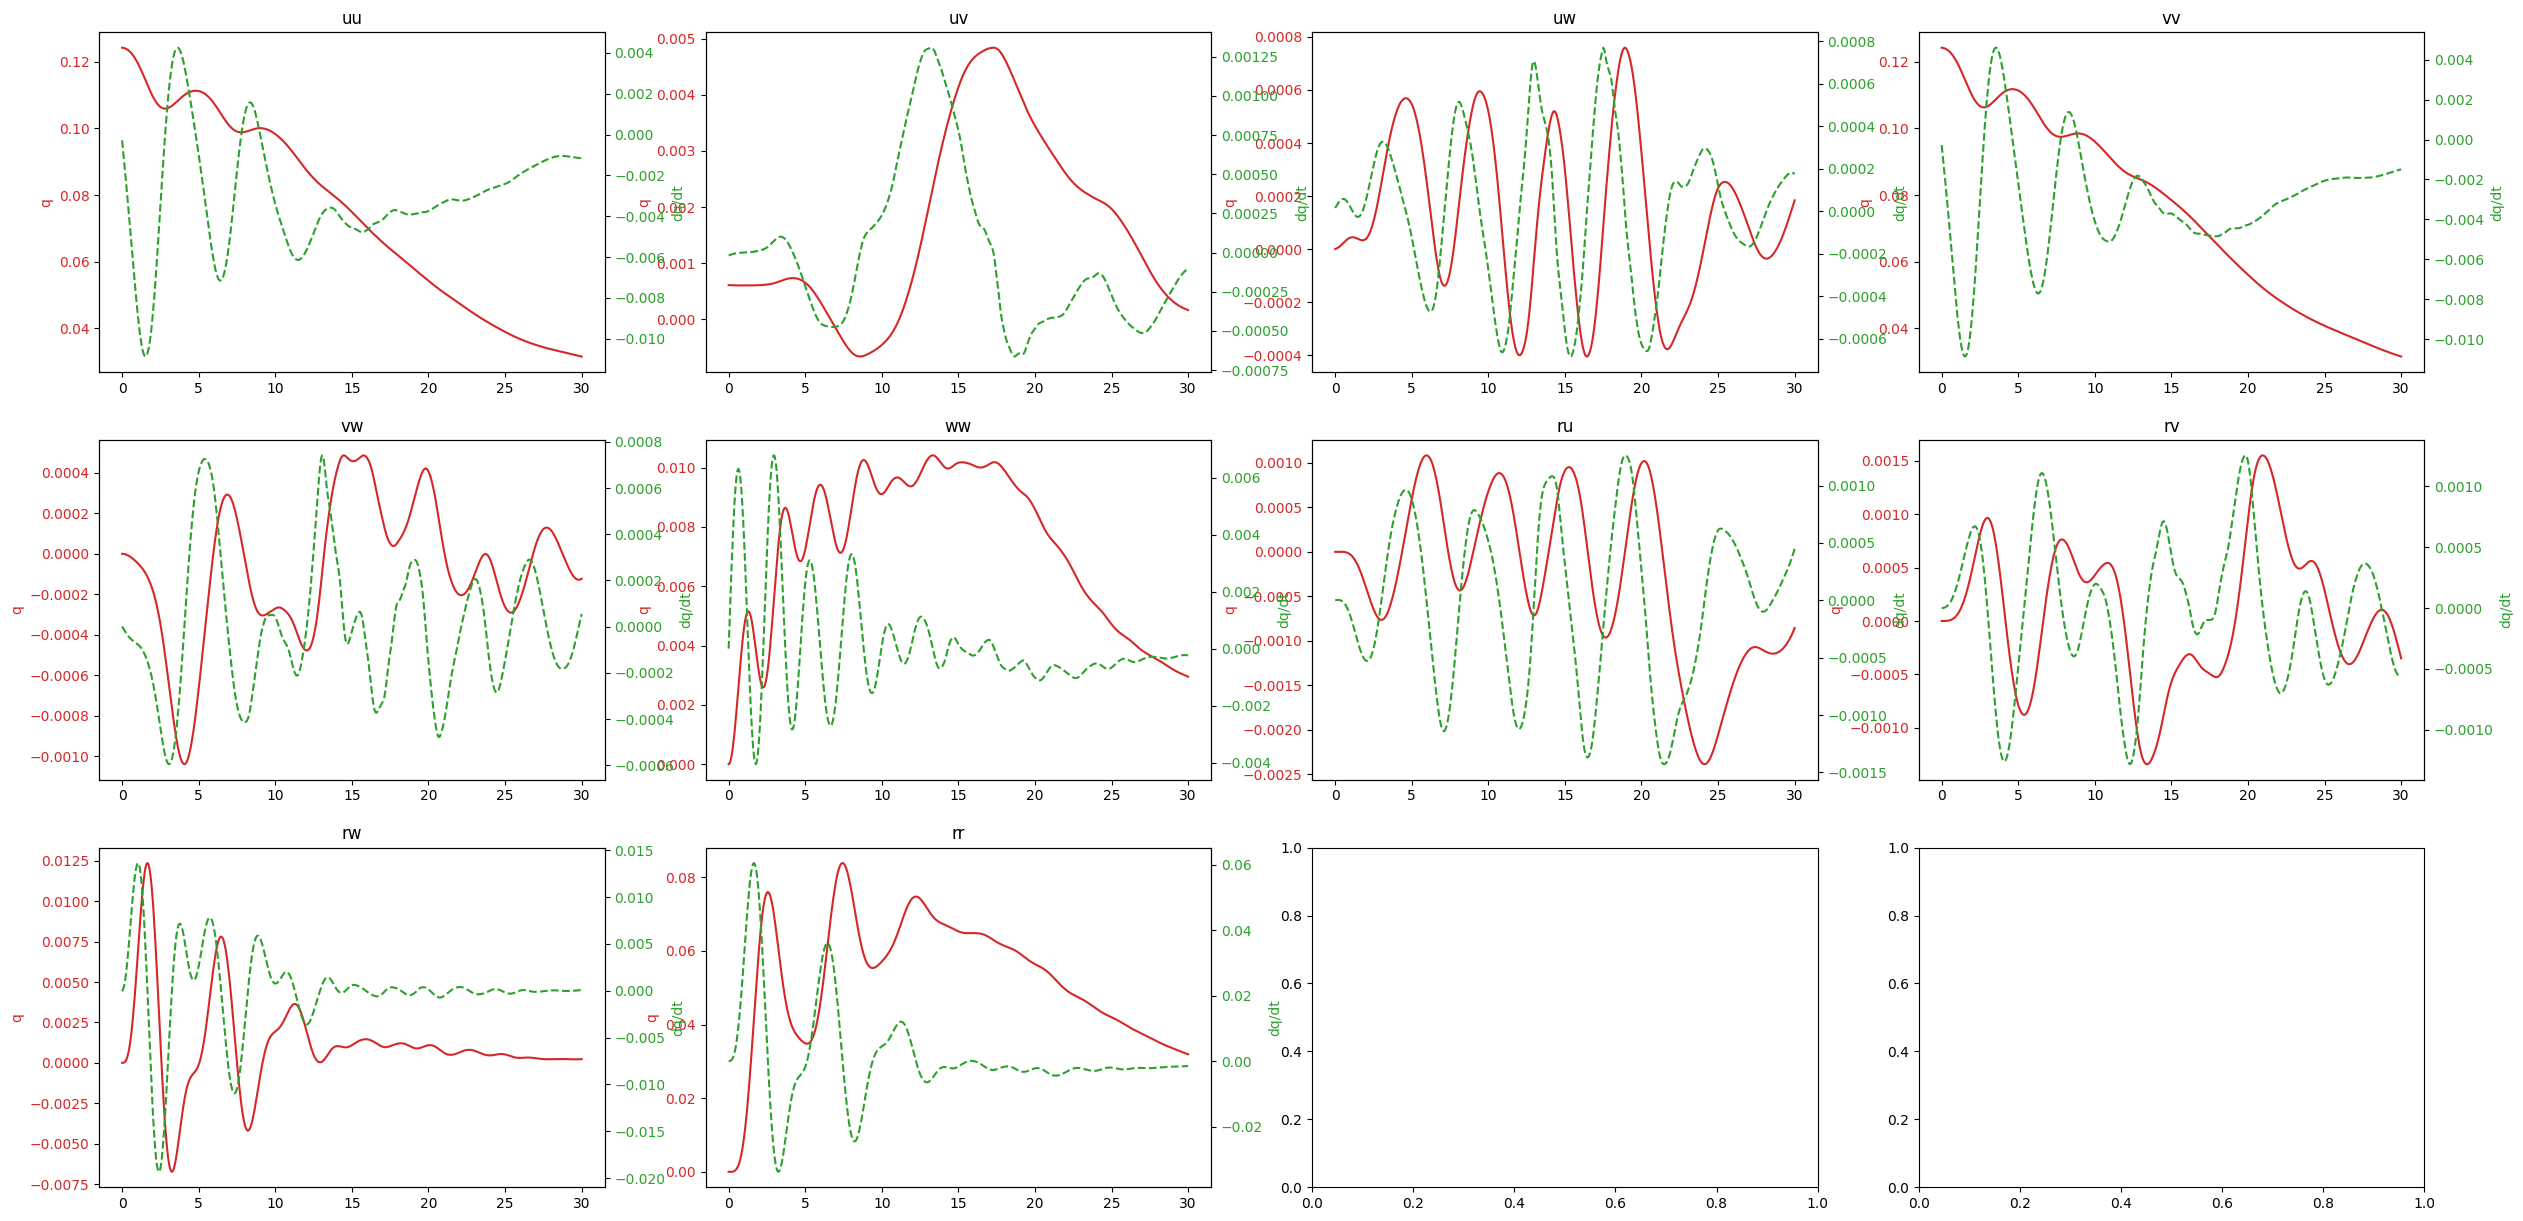

In [5]:
filename = case_info.HDdir+'rstats'
rstats = statsData(filename)

fig, axs = plt.subplots(3,4,figsize=(30,15))
axs = axs.ravel()
for i in range(rstats.nvars-1):
    color = 'tab:red'
    axs[i].set_ylabel('q', color = color)
    axs[i].plot(rstats.values[:,rstats.IDt], rstats.values[:,i+1], '-', color = color)
    axs[i].tick_params(axis ='y', labelcolor = color)
    
    ax2 = axs[i].twinx()
    color = 'tab:green'
    ax2.set_ylabel('dq/dt', color = color)
    ax2.plot(rstats.values[:,rstats.IDt], rstats.values_dt[:,i], '--', color = color)
    ax2.tick_params(axis ='y', labelcolor = color)
    axs[i].set_title(rstats.varnames[i+1])

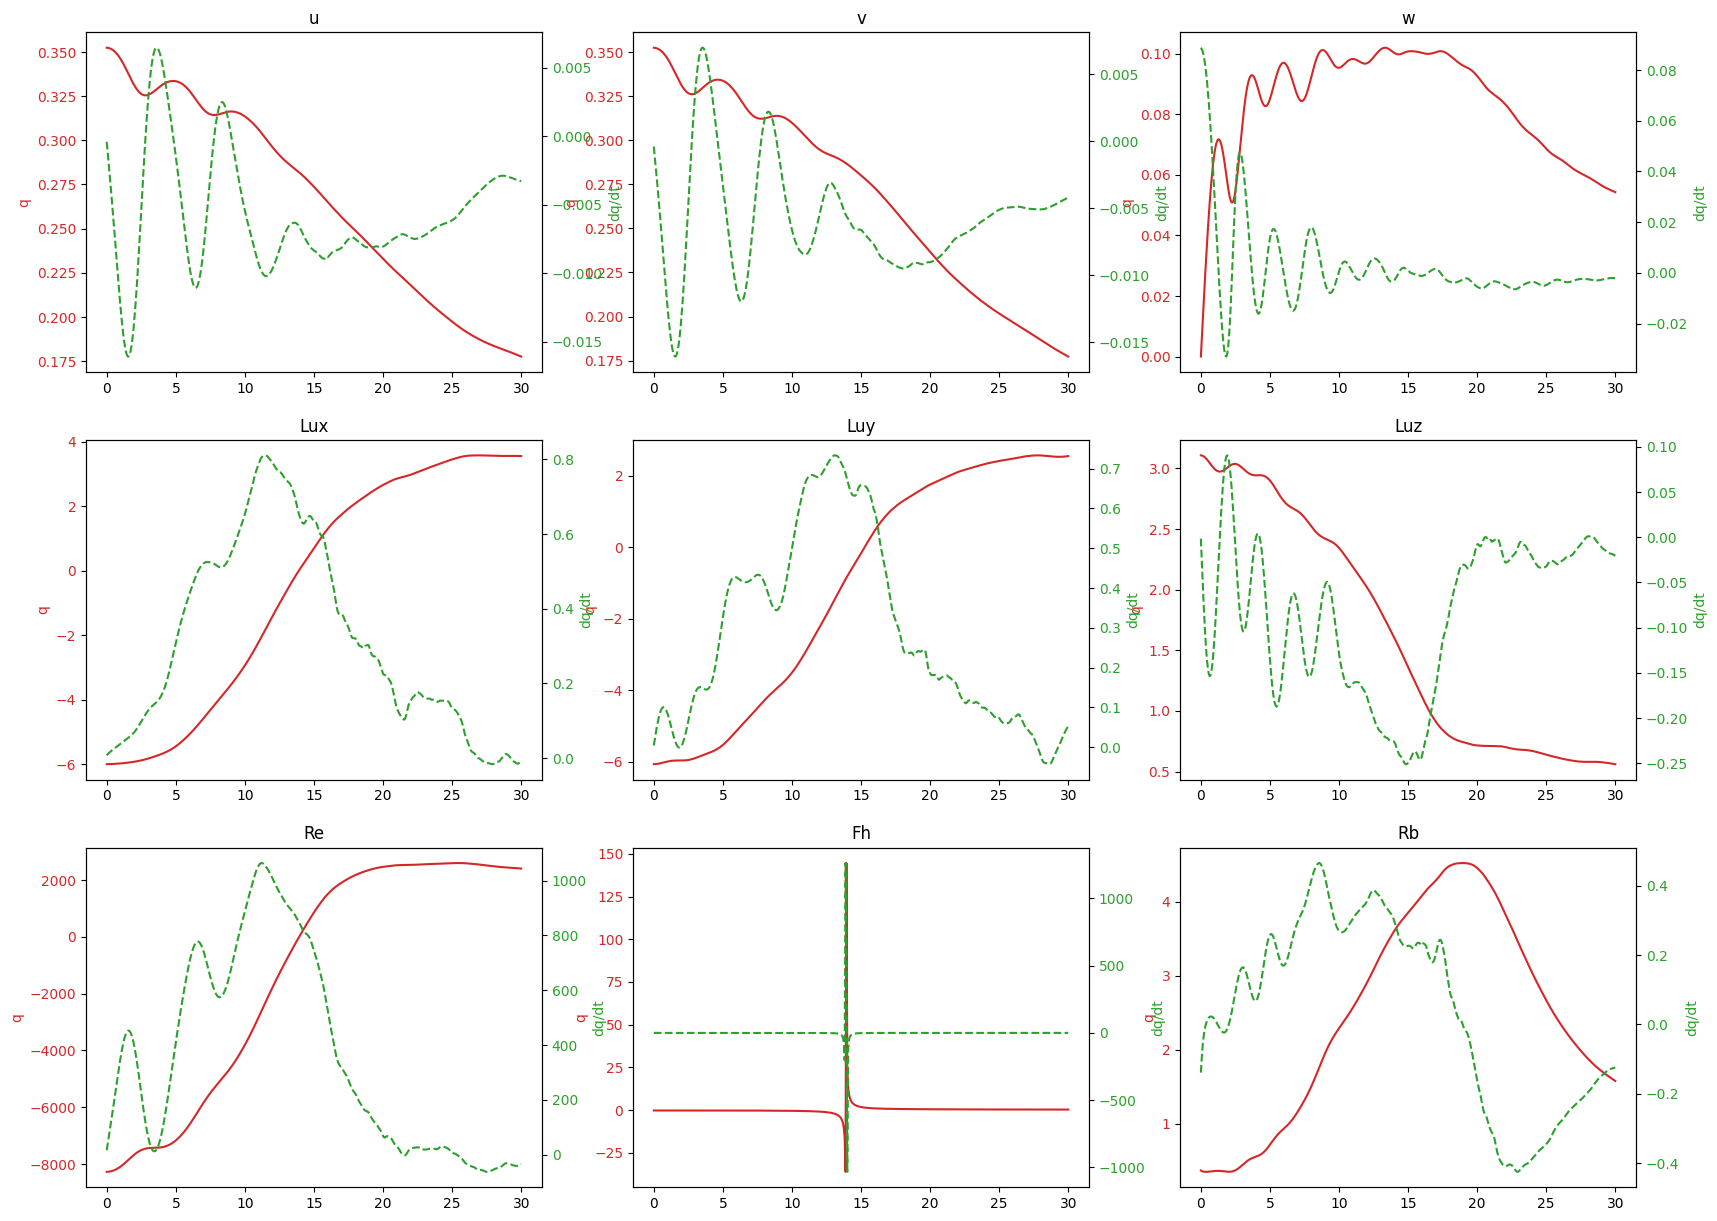

In [6]:
if case_info.casename[-1]=='a':
    filename = case_info.HDdir+'vstats'
else:
    filename = case_info.HDdir+'vstats2'
vstats = statsData(filename)

fig, axs = plt.subplots(3,3,figsize=(20,15))
axs = axs.ravel()
for i in range(vstats.nvars-1):
    color = 'tab:red'
    axs[i].set_ylabel('q', color = color)
    axs[i].plot(vstats.values[:,vstats.IDt], vstats.values[:,i+1], '-', color = color)
    axs[i].tick_params(axis ='y', labelcolor = color)
    
    ax2 = axs[i].twinx()
    color = 'tab:green'
    ax2.set_ylabel('dq/dt', color = color)
    ax2.plot(vstats.values[:,vstats.IDt], vstats.values_dt[:,i], '--', color = color)
    ax2.tick_params(axis ='y', labelcolor = color)
    axs[i].set_title(vstats.varnames[i+1])

## Compute variables

In [7]:
# Compute B (bw) and b2
if case_info.casename[-1]=='a':  # gravity in y-direction
    B = rstats.values[:,rstats.ID('rv')]  * (case_info.accel/case_info.rho0)
else:
    B = rstats.values[:,rstats.ID('rw')]  * (case_info.accel/case_info.rho0)
bb = rstats.values[:,rstats.ID('rr')]  * (case_info.accel/case_info.rho0)**2

# Compute energies
uu = rstats.values[:,rstats.ID('uu')]
if case_info.casename[-1]=='a':  # gravity in y-direction
    vv = rstats.values[:,rstats.ID('ww')]
    ww = rstats.values[:,rstats.ID('vv')]
else:
    vv = rstats.values[:,rstats.ID('vv')]
    ww = rstats.values[:,rstats.ID('ww')]
uH = uu + vv
ke = 0.5 * (uH + ww)
pe = bb / (2 * case_info.N**2)
totalE = ke + pe

# Compute Frh and Gn
# eps = mestats.values[:,mestats.ID('eps')]
# k = 0.5 * (uH + ww)
# Frt = eps / (N * uH)
# Frt = 2 * np.pi * U / (N * (U**3/eps))
# Gn  = eps / (nu * N**2)
Frh = vstats.values[:,vstats.ID('Fh')]
dkedt = np.gradient(ke, rstats.values[:,rstats.IDt], edge_order=2, axis=0)
epsilon = -(B) - dkedt
Frt = 2*np.pi*epsilon / (case_info.N * np.sqrt(uu+vv+ww))
if case_info.casename[-1]=='a':  # use Gn
    Gn = vstats.values[:,vstats.ID('Gn')]
else:
    Gn = vstats.values[:,vstats.ID('Rb')]

## Plots

### Total energy

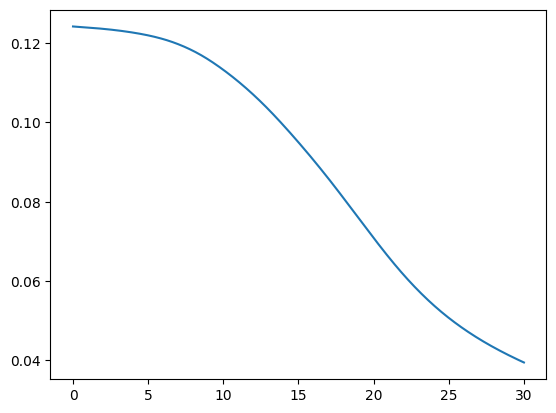

In [8]:
plt.plot(rstats.values[:,rstats.IDt], totalE, '-');
# plt.yscale('log')
# plt.xscale('log')

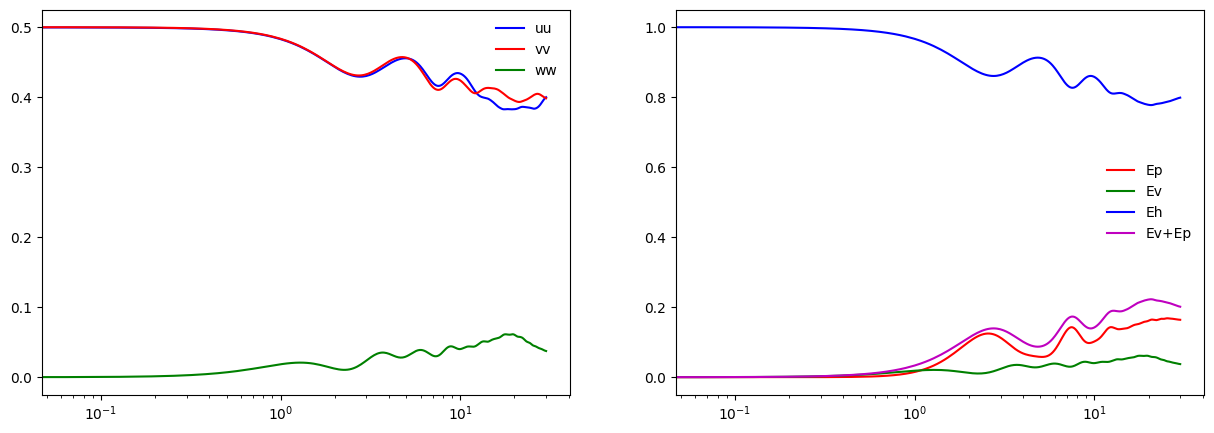

In [9]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs = axs.ravel()

axs[0].plot(rstats.values[:,rstats.IDt], 0.5*uu/totalE, '-b', label='uu')
axs[0].plot(rstats.values[:,rstats.IDt], 0.5*vv/totalE, '-r', label=f'vv')
axs[0].plot(rstats.values[:,rstats.IDt], 0.5*ww/totalE, '-g', label=f'ww')
axs[0].set_xscale('log')
axs[0].legend(frameon=False);

axs[1].plot(rstats.values[:,rstats.IDt], pe/totalE, '-r', label='Ep')
axs[1].plot(rstats.values[:,rstats.IDt], 0.5*ww/totalE, '-g', label='Ev')
axs[1].plot(rstats.values[:,rstats.IDt], 0.5*uH/totalE, '-b', label='Eh')
axs[1].plot(rstats.values[:,rstats.IDt], (0.5*ww + pe)/totalE, '-m', label='Ev+Ep')
axs[1].set_xscale('log')
axs[1].legend(frameon=False);

### Fr & Gn

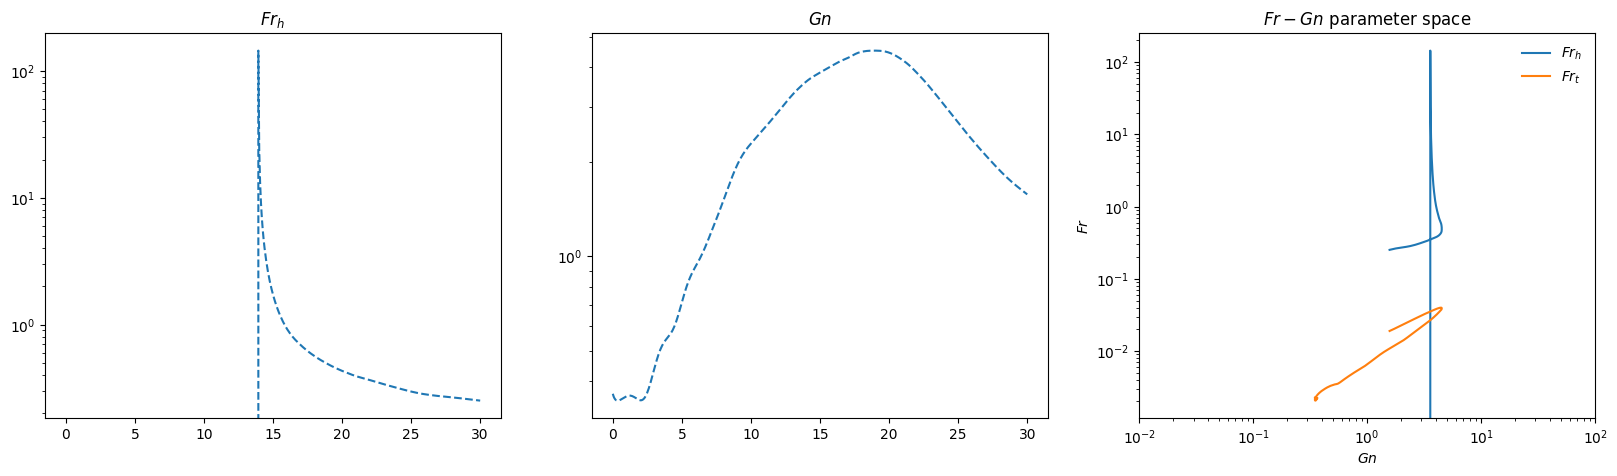

In [10]:
fig, axs = plt.subplots(1,3,figsize=(20,5))
axs = axs.ravel()
axs[0].plot(rstats.values[:,rstats.IDt], Frh, '--')
# axs[0].plot(rstats.values[:,rstats.IDt], Frt, '--')
axs[0].set_title(f'$Fr_h$')
axs[0].set_yscale('log')
axs[1].plot(rstats.values[:,rstats.IDt], Gn, '--')
axs[1].set_title(f'$Gn$')
axs[1].set_yscale('log')
axs[2].plot(Gn, Frh, '-', label=r'$Fr_h$')
axs[2].plot(Gn, Frt, '-', label=r'$Fr_t$')
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel(f'$Gn$')
axs[2].set_ylabel(f'$Fr$')
axs[2].legend(frameon=False)
axs[2].set_xlim([1e-2, 1e2])
# axs[2].set_ylim([1e-3, 1e0])
axs[2].set_title(f'$Fr - Gn$ parameter space');

### Testing data

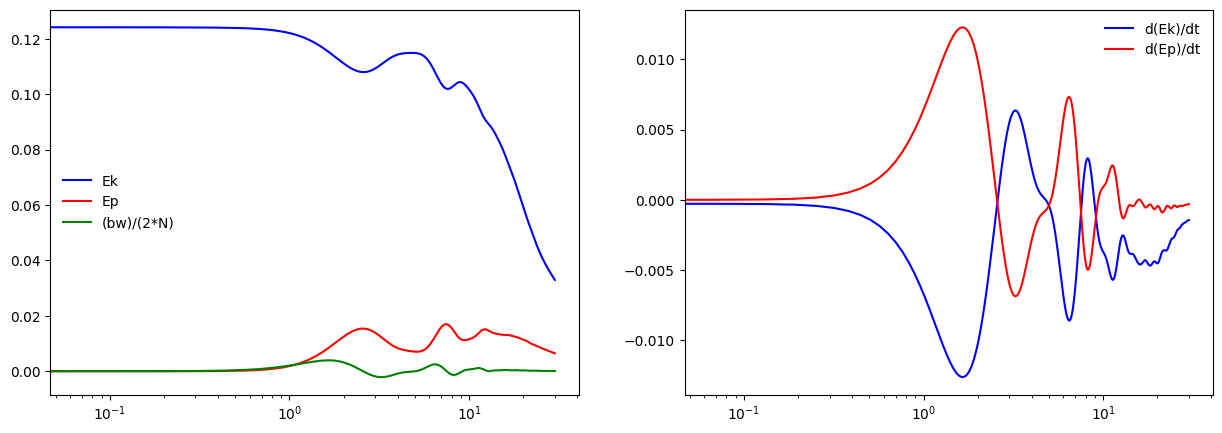

In [11]:
dkedt = np.gradient(ke, rstats.values[:,rstats.IDt], edge_order=2, axis=0)
dpedt = np.gradient(pe, rstats.values[:,rstats.IDt], edge_order=2, axis=0)
t_ke = ke/dkedt
t_pe = pe/dpedt

fig, axs = plt.subplots(1,2,figsize=(15,5))
axs = axs.ravel()

axs[0].plot(rstats.values[:,rstats.IDt], ke, '-b', label='Ek')
axs[0].plot(rstats.values[:,rstats.IDt], pe, '-r', label='Ep')
axs[0].plot(rstats.values[:,rstats.IDt], B/(2*case_info.N), '-g', label='(bw)/(2*N)')
axs[0].set_xscale('log')
axs[0].legend(frameon=False);

axs[1].plot(rstats.values[:,rstats.IDt], dkedt, '-b', label='d(Ek)/dt')
axs[1].plot(rstats.values[:,rstats.IDt], dpedt, '-r', label='d(Ep)/dt')
axs[1].set_xscale('log')
axs[1].legend(frameon=False);

# Save data

## Choose input & output data

In [12]:
data_time = rstats.values[:,rstats.IDt].copy()

if normEnergy:
    data_ip = np.array( [ uH/(2*totalE[0]), 
                         ww/(2*totalE[0]), 
                         bb/(2*case_info.N**2 * totalE[0]), 
                         B/(2*case_info.N*totalE[0]) ] ).T
    data_ip_varnames = [ 'uH2/2*Et0', 'ww/2*Et0', 'b2/2*N2*Et0', 'bw/2*N*Et0' ]
else:
    data_ip = np.array( [ uH, ww,
                         bb,
                         B ] ).T
    data_ip_varnames = [ 'uH2', 'ww' , 'b2', 'bw' ]

# =========Output=========
# time derivative of Energy terms
if normEnergy:
    data_op   = np.gradient(data_ip[:,:], data_time, edge_order=2, axis=0)
    data_op_varnames = [ 'd(Eh/Et0)/dt', 'd(Ev/Et0)/dt', 'd(Ep/Et0)/dt', 'd(bw/2*N*Et0)/dt' ]
else:
    data_op = np.array( [ uH/2, ww/2,
                         pe,
                         B ] ).T
    data_op   = np.gradient(data_op[:,:], data_time, edge_order=2, axis=0)
    data_op_varnames = [ 'd(Eh)/dt', 'd(Ev)/dt', 'd(Ep)/dt', 'd(bw)/dt' ]


# =======================
# interpolate data to finer time instants from time conversion files
if int(str(case)[0])>1:
    # interp i/p
    finterp = interpolate.interp1d(data_time, data_ip, axis=0, kind='cubic', fill_value="extrapolate")
    data_time_dim = tstats.values[:,tstats.ID('dim_t')]
    data_ip = finterp(data_time_dim)
    # interp o/p
    finterp = interpolate.interp1d(data_time, data_op, axis=0, kind='cubic', fill_value="extrapolate")
    data_op = finterp(data_time_dim)
    # interp Frh & Gn
    finterp = interpolate.interp1d(data_time, Frh, axis=0, kind='linear', fill_value="extrapolate")
    Frh = finterp(data_time_dim)
    finterp = interpolate.interp1d(data_time, Gn, axis=0, kind='linear', fill_value="extrapolate")
    Gn = finterp(data_time_dim)
    data_time_t = tstats.values[:,tstats.ID('t')]
    data_time_T = tstats.values[:,tstats.ID('T')]

# =======================
# choose appropriate time data
if case_info.normTime:
    # # use dimensionless time, t
    # if int(str(case)[0])>1:
    #     data_time = data_time_t
    # else:
    #     data_time = (data_time - case_info.t0) / (case_info.tLe)
    # time_varname = ['t']
    # use buoyancy time period, T
    if int(str(case)[0])>1:
        data_time = data_time_T
    else:
        data_time = ( ((data_time - case_info.t0) / case_info.tLe) - 1 ) / case_info.Fr
    time_varname = ['T']
else: # use dimensional time, \hat{t}
    if int(str(case)[0])>1:
        data_time = data_time_dim
    time_varname = ['\hat{t}']

# =======================
# interpolate data to have constant dt
if interpIO:
    if set_dt_seq:    # set dt such that time length of seq_len data = dt_T time period
        dt = dt_T/seq_len
    else:
        dt = np.mean(np.diff(data_time))  # min or mean??
    data_time_temp = data_time.copy()
    data_time = np.arange(data_time_temp[0], data_time_temp[-1], dt)
    # interp i/p
    finterp = interpolate.interp1d(data_time_temp, data_ip, axis=0, kind='cubic', fill_value="extrapolate")
    data_ip = finterp(data_time)
    # interp o/p
    if normEnergy:
        data_op = np.gradient(data_ip[:,:], data_time, edge_order=2, axis=0)
    else:
        finterp = interpolate.interp1d(data_time_temp, data_op, axis=0, kind='cubic', fill_value="extrapolate")
        data_op = finterp(data_time)
    # filter gradient data due to discontinuities from numerical differentiation
    data_op_temp = np.copy(data_op)
    if case_info.filtgrad:
        data_op = gaussian_filter1d(data_op, sigma=case_info.filtgrad_sigma, axis=0)
        plt.plot(data_time, data_op_temp[:,0], label='before filtering')
        plt.plot(data_time, data_op[:,0], '--', label='after filtering')
        plt.xlim([0,3])
        plt.legend(frameon=False)
        if np.max(np.abs(data_op_temp - data_op)) > 1e0:
            raise Exception(f"High error in filtering!!!! {np.max(np.abs(data_op_temp - data_op))}")
    # interp Frh & Gn
    finterp = interpolate.interp1d(data_time_temp, Frh, axis=0, kind='linear', fill_value="extrapolate")
    Frhinterp = finterp(data_time)
    finterp = interpolate.interp1d(data_time_temp, Gn, axis=0, kind='linear', fill_value="extrapolate")
    Gninterp = finterp(data_time)

# =======================
# skip transient data
if case_info.Tskip>0:
    ID = np.where(data_time > case_info.Tskip)[0]
    data_time = data_time[ID]
    data_ip   = data_ip  [ID,:]
    data_op   = data_op  [ID,:]
    Frhinterp = Frhinterp[ID]
    Gninterp  = Gninterp [ID]

# =======================
# skip end of data
if case_info.Gnfinal>0 and case_info.Gnfinal>Gninterp[-1]:
    ID = np.where(Gninterp > case_info.Gnfinal)[0]
    data_time = data_time[ID]
    data_ip   = data_ip  [ID,:]
    data_op   = data_op  [ID,:]
    Frhinterp = Frhinterp[ID]
    Gninterp  = Gninterp [ID]

# =======================
# add additional inputs
if add_IP_ke_pe_T:
    dkedt_interp = data_op[:,id_uH] + data_op[:,id_ww]
    dpedt_interp = data_op[:,id_bb]
    epsilon_interp = (-data_ip[:,id_bw]) - dkedt_interp  # -bw - d(ke)/dt
    chi_interp     =  data_ip[:,id_bw]   - dpedt_interp  # bw - d(pe)/dt
    t_ke = (data_ip[:,id_uH]+data_ip[:,id_ww]) / epsilon_interp # ke / epsilon
    t_pe = data_ip[:,id_bb] / chi_interp # pe / chi
    data_ip = np.append( data_ip, np.array([epsilon_interp, chi_interp]).T, axis=1 )
    data_ip_varnames += ['epsilon', 'chi']

if add_IP_Fr_Gn:
    data_ip = np.append( data_ip, np.array([Frhinterp, Gninterp]).T, axis=1 )
    data_ip_varnames += ['Frh', 'Gn']

if add_IP_time:
    data_ip = np.append( data_ip, np.array([data_time]).T, axis=1)
    data_ip_varnames += time_varname

# force normalize input/output
if normIO:
    data_op = ( data_op - np.min(data_op, axis=0) ) / (np.max(data_op, axis=0) - np.min(data_op, axis=0))

Nsampls   = len(data_time)

print(f'# input variables:\t{data_ip.shape[1]}\n# output variables:\t{data_op.shape[1]}\n# samples:\t\t{Nsampls:,}')

print(f'seq len for 1T length of data = {round(1/np.diff(data_time)[0])}')

# input variables:	4
# output variables:	4
# samples:		1,920
seq len for 1T length of data = 64


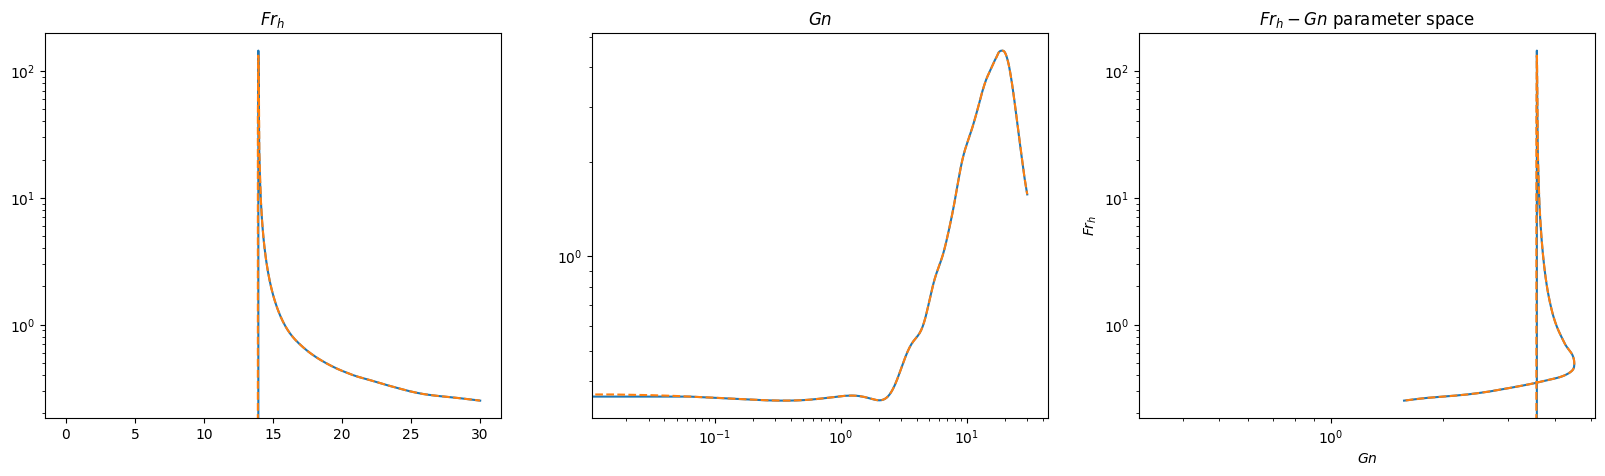

In [13]:
fig, axs = plt.subplots(1,3,figsize=(20,5))
axs = axs.ravel()
axs[0].plot(data_time_temp, Frh, '-')
axs[0].plot(data_time, Frhinterp, '--')
axs[0].set_title(f'$Fr_h$')
axs[0].set_yscale('log')
axs[1].plot(data_time_temp, Gn, '-')
axs[1].plot(data_time, Gninterp, '--')
axs[1].set_title(f'$Gn$')
axs[1].set_yscale('log')
axs[1].set_xscale('log')
# axs[1].set_ylim([0.1, 100])
axs[2].plot(Gn, Frh, '-')
axs[2].plot(Gninterp, Frhinterp, '--')
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel(f'$Gn$')
axs[2].set_ylabel(f'$Fr_h$')
# axs[2].set_xlim([1e-2, 1e1])
# axs[2].set_ylim([1e-1, 2e0])
axs[2].set_title(f'$Fr_h - Gn$ parameter space');

## Generate LSTM data

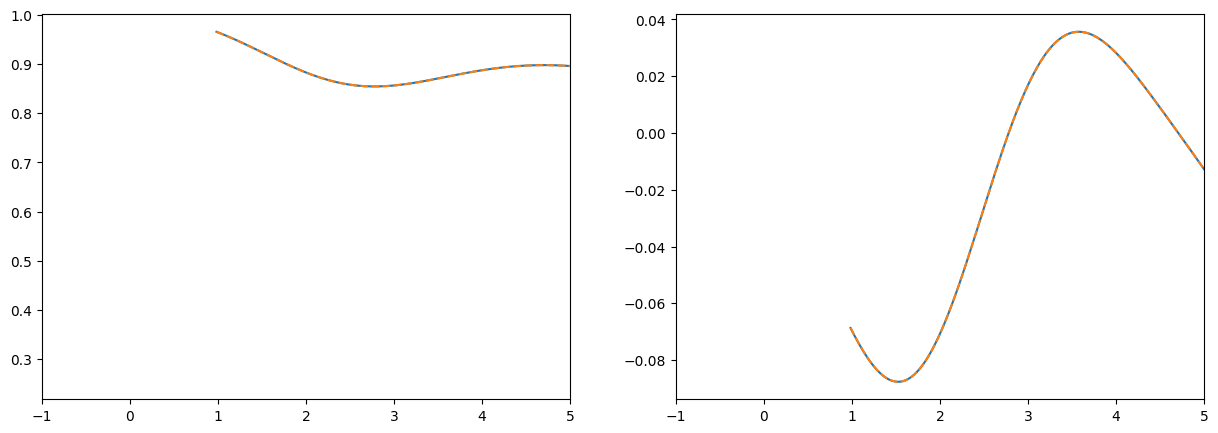

In [14]:
data_ip_lstm = np.zeros( (Nsampls-seq_len+1, seq_len, data_ip.shape[1]) )
data_op_lstm = np.zeros( (Nsampls-seq_len+1, data_op.shape[1]) )

for i in range(Nsampls-seq_len+1):
    data_ip_lstm[i,:,:] = data_ip[i:i+seq_len,:]
    data_op_lstm[i,:]   = data_op[i+seq_len-1,:]

data_time_lstm = data_time[seq_len-1:]
Nsampls = len(data_time_lstm)

# validating data with original data
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs = axs.ravel()
axs[0].plot(data_time_lstm, data_ip_lstm[:,-1,0])
axs[0].plot(data_time_lstm, data_ip[seq_len-1:,0],'--')
axs[0].set_xlim([-1,5])
axs[1].plot(data_time_lstm, data_op_lstm[:,0])
axs[1].plot(data_time_lstm, data_op[seq_len-1:,0],'--');
axs[1].set_xlim([-1,5]);

## Validate energy time scales

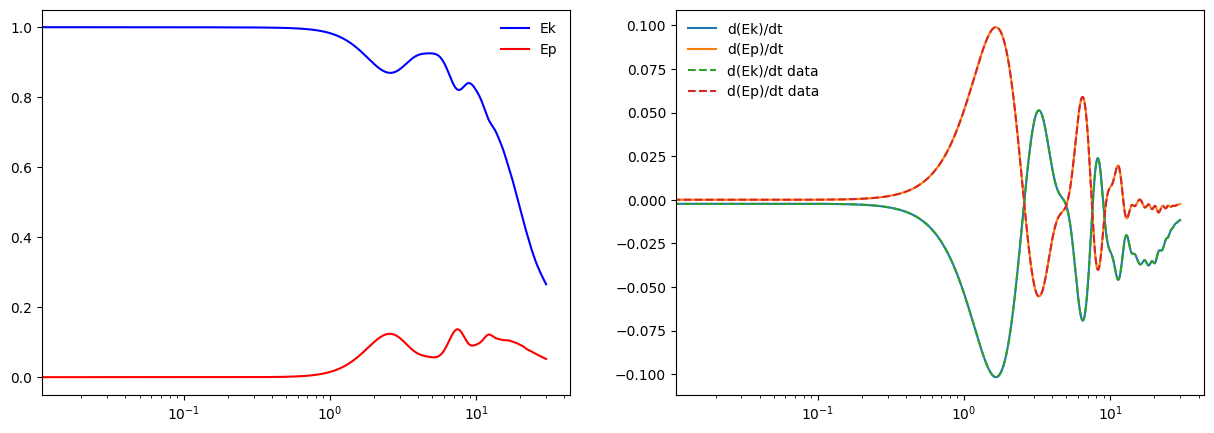

In [15]:
ke_interp = data_ip[:,0]+data_ip[:,1]
pe_interp = data_ip[:,2]
dkedt_interp = np.gradient(ke_interp, data_time, edge_order=2, axis=0)
dpedt_interp = np.gradient(pe_interp, data_time, edge_order=2, axis=0)
dkedt_interp1 = data_op[:,0] + data_op[:,1]
dpedt_interp1 = data_op[:,2]

fig, axs = plt.subplots(1,2,figsize=(15,5))
axs = axs.ravel()

axs[0].plot(data_time, ke_interp, '-b', label='Ek')
axs[0].plot(data_time, pe_interp, '-r', label='Ep')
axs[0].set_xscale('log')
axs[0].legend(frameon=False);

axs[1].plot(data_time, dkedt_interp, '-', label='d(Ek)/dt')
axs[1].plot(data_time, dpedt_interp, '-', label='d(Ep)/dt')
axs[1].plot(data_time, dkedt_interp1, '--', label='d(Ek)/dt data')
axs[1].plot(data_time, dpedt_interp1, '--', label='d(Ep)/dt data')
axs[1].set_xscale('log')
axs[1].legend(frameon=False);

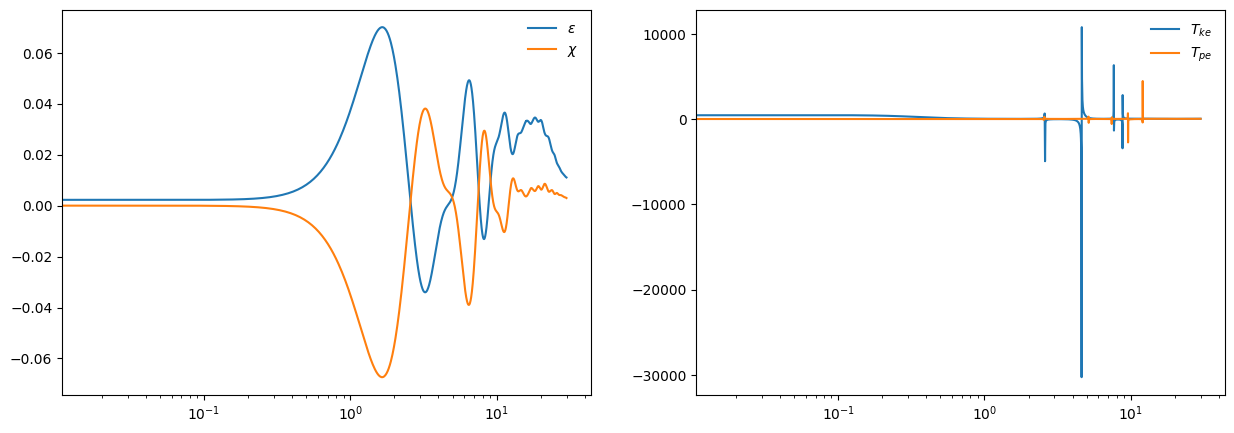

In [16]:
# epsilon_interp = (-data_ip[:,-1]) - (dkedt_interp/case_info.N)
# chi_interp     = data_ip[:,-1] - (dpedt_interp/case_info.N)
epsilon_interp = (-data_ip[:,3]) - dkedt_interp1
chi_interp     = data_ip[:,3] - dpedt_interp1
t_ke = ke_interp/epsilon_interp
t_pe = pe_interp/chi_interp

fig, axs = plt.subplots(1,2,figsize=(15,5))
axs = axs.ravel()

axs[0].plot(data_time, epsilon_interp, '-', label=r'$\epsilon$')
axs[0].plot(data_time, chi_interp, '-', label=r'$\chi$')
# axs[0].plot(data_time, data_op[:,0]+data_op[:,1], '--', label=r'$\epsilon$')
# axs[0].plot(data_time, data_op[:,2], '-r', label=r'$\chi$')
axs[0].set_xscale('log')
axs[0].legend(frameon=False);

axs[1].plot(data_time, t_ke, '-', label=r'$T_{ke}$')
axs[1].plot(data_time, t_pe, '-', label=r'$T_{pe}$')
axs[1].set_xscale('log')
axs[1].legend(frameon=False);

In [17]:
print(f'min dt:\t{np.min(np.diff(data_time_lstm))}\nmax dt:\t{np.max(np.diff(data_time_lstm))}\navg dt:\t{np.mean(np.diff(data_time_lstm))}\nstd dt:\t{np.std(np.diff(data_time_lstm))}')

min dt:	0.015625
max dt:	0.015625
avg dt:	0.015625
std dt:	0.0


## Split data train & testing

In [18]:
# compute number of samples for training & testing
Ntrain = int(Nsampls * Ntrainper)
Ntest = Nsampls - Ntrain
if shuffledata: samplList = np.random.permutation(np.arange(0,Nsampls - Ntest))
else: samplList = np.arange(0,Nsampls - Ntest)

if Ntrain>len(samplList):
    print("Need more samples!!!!!")
else:
    samplList = samplList[0:Ntrain]
    # Training data
    datatrain_IP = data_ip_lstm[samplList, :]
    datatrain_OP = data_op_lstm[samplList, :]
    # Testing data
    datatest_IP = data_ip_lstm[Nsampls-Ntest:, :]
    datatest_OP = data_op_lstm[Nsampls-Ntest:, :]
    # time stamps
    datatrain_time = data_time_lstm[samplList]
    datatest_time  = data_time_lstm[Nsampls-Ntest:]

## Validate data

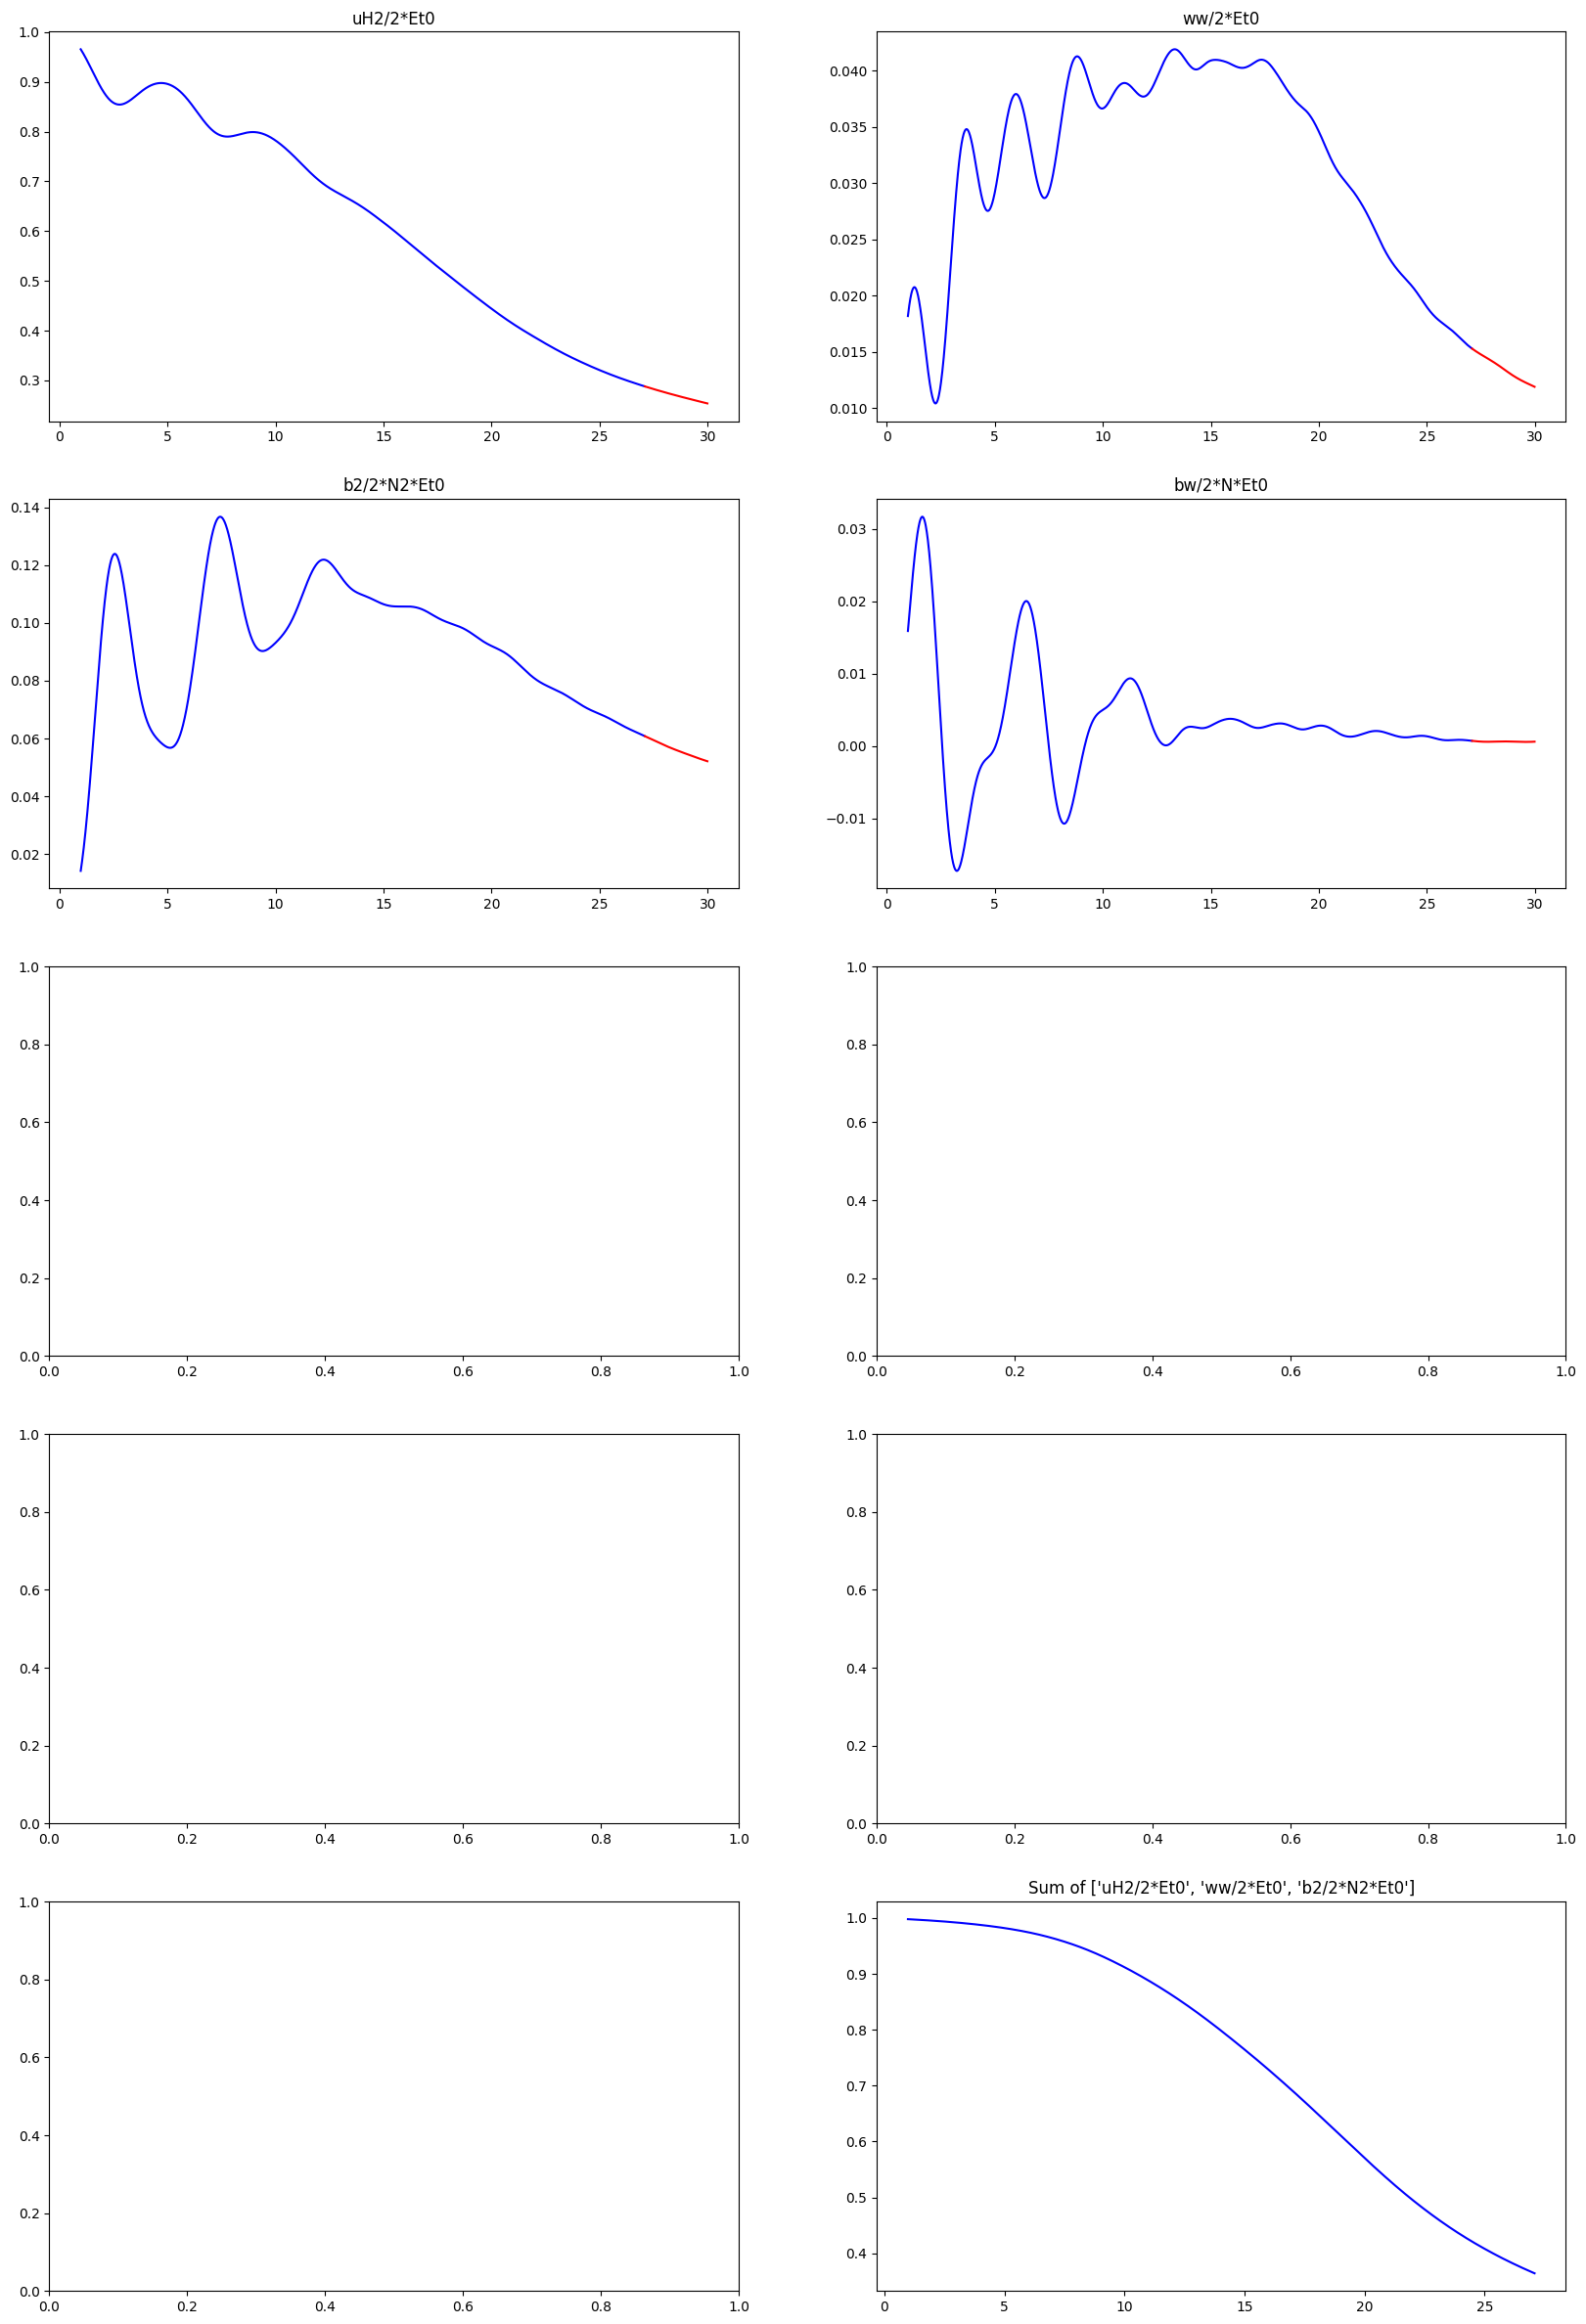

In [19]:
nin = data_ip.shape[1]; nop = data_op.shape[1];

if ~shuffledata:
    fig, axs = plt.subplots(5,2,figsize=(20,30))
    axs = axs.ravel()
    for i in range(nin):
        axs[i].plot(datatrain_time, datatrain_IP[:,-1,i], 'b-')
        axs[i].plot(datatest_time, datatest_IP[:,-1,i], 'r-')
        axs[i].set_title(data_ip_varnames[i])
        # axs[i].set_xlim([0,50])
    axs[-1].plot(datatrain_time, np.sum(datatrain_IP[:,-1,0:3], axis=1), 'b-')
    axs[-1].set_title(f'Sum of {data_ip_varnames[0:3]}')

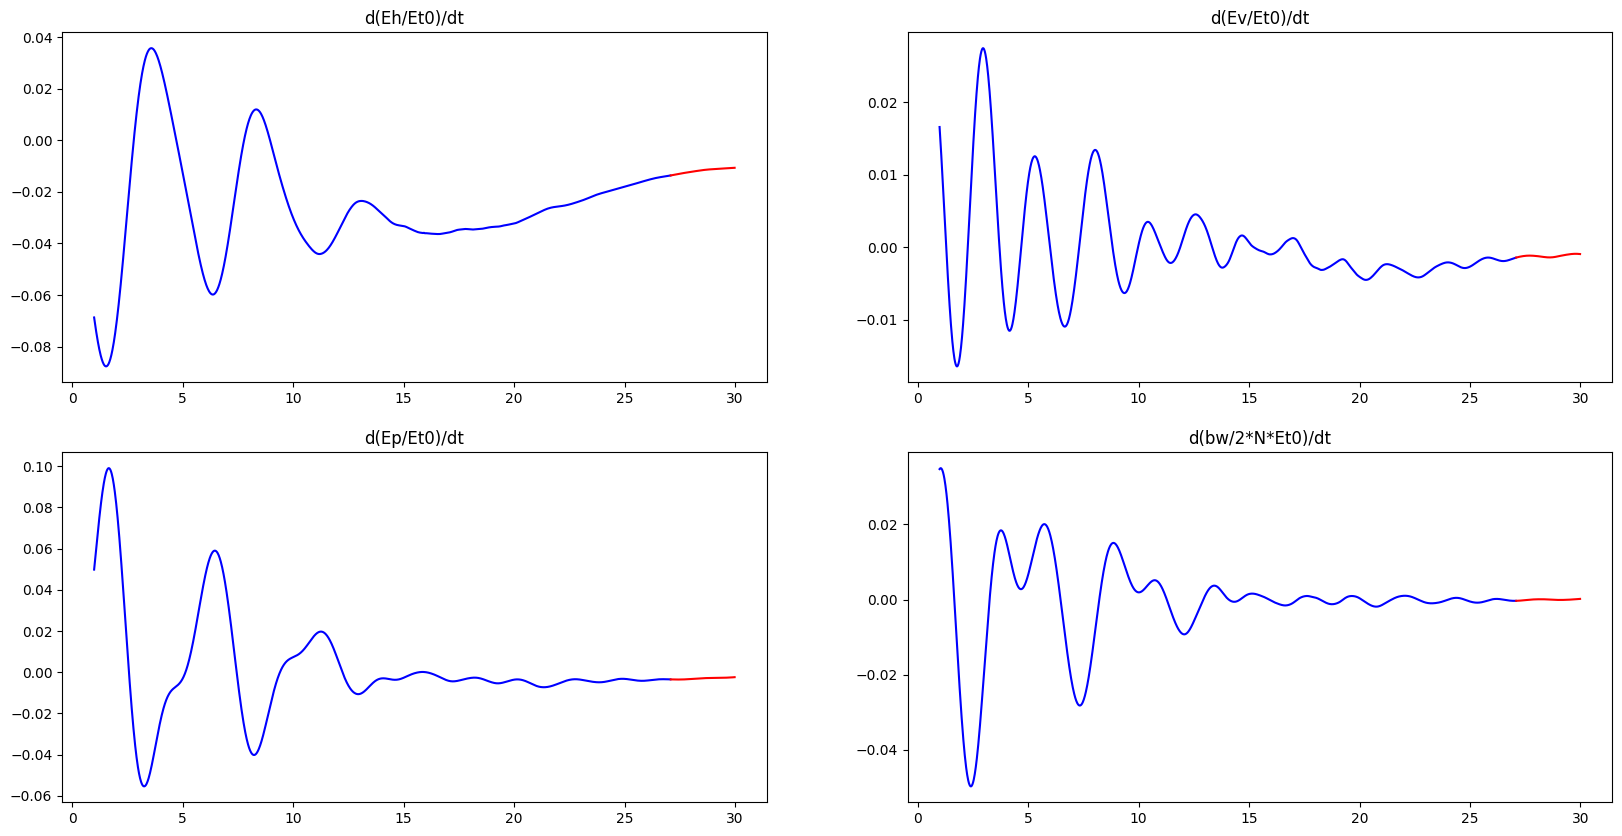

In [20]:
if ~shuffledata:
    fig, axs = plt.subplots(2,2,figsize=(20,10))
    axs = axs.ravel()
    for i in range(nop):
        axs[i].plot(datatrain_time, datatrain_OP[:,i], 'b-')
        axs[i].plot(datatest_time, datatest_OP[:,i], 'r-')
        axs[i].set_title(data_op_varnames[i])
        # axs[i].set_xlim([1,50])

## Save to npz file

In [21]:
if savedata:
    np.savez(savefilename,
             Ntrain=Ntrain, Ntest=Ntest, 
             datatrain_IP=datatrain_IP, datatrain_OP=datatrain_OP, 
             datatest_IP=datatest_IP, datatest_OP=datatest_OP,
             data_ip_varnames=data_ip_varnames, data_op_varnames=data_op_varnames,
             datatrain_time=datatrain_time, datatest_time=datatest_time,
             nu=case_info.nu, drhobardz=case_info.drhobardz, accel=case_info.accel, rho0=case_info.rho0, totalE=totalE,
             Frh=Frhinterp, Gn=Gninterp, data_time=data_time)